In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [56]:
def get_unique_value_lengths(dataframe: pd.DataFrame, col_name: str):
    unique_vals = map(lambda r: str(r), dataframe[col_name].unique())
    unique_vals = filter(lambda r: r != 'nan', unique_vals)
    unique_vals = map(lambda r: len(r), unique_vals)
    unique_vals = list(unique_vals)
    return np.array(unique_vals)

def inferred_type(dataframe: pd.DataFrame, col_name: str, max_cat_value_count: int=1000) -> np.dtype:
    is_datetime_col = dataframe[col_name].str.match('(\d{2,4}(-|\/|\\|\.| )\d{2}(-|\/|\\|\.| )\d{2,4})+').all()
    if is_datetime_col:
        return 'datetime'
    
    is_int32 = dataframe[col_name].str.match('\d{1,6}$').all()
    if is_int32:
        return 'int32'
    
    is_float = dataframe[col_name].str.match(r'\d{1,6}(\.\d{1,5})?$').all()
    if is_float:
        return 'float'
    
    unique_vals = dataframe[col_name].unique()
    n_unique = unique_vals.shape[0]

    if n_unique == 2 or n_unique == 3:
        bool_vals = np.array(['(N/A)', 'N', 'Y'], dtype='str')
        possible_bool_vals = np.array(pd.DataFrame(unique_vals).fillna('(N/A)')[0])
        if np.isin(possible_bool_vals, bool_vals).all():
            return 'bool'
    
    if n_unique >= 2 and n_unique < max_cat_value_count:
        unique_val_lengths = get_unique_value_lengths(dataframe, col_name)
        if np.max(unique_val_lengths) > 300:
            # print(f'{col_name} -> {np.max(unique_val_lengths)}')
            return 'object'
        return 'category'

    return 'object'

def filter_rows(dataframe: pd.DataFrame, min_count_per_category: int=50):
    # Count number of rows per category
    df_count_by_category = dataframe.groupby('category_name').agg({'id': 'count'}).rename(columns={'id': 'n_rows'})

    # Find categories with at least N amount of rows
    categories = list(df_count_by_category[df_count_by_category.n_rows > min_count_per_category].index)

    # Delete rows with few that N amount of rows per category
    return dataframe[dataframe.category_name.isin(categories)]

def filter_columns(dataframe: pd.DataFrame, min_count_per_feature:int=10):
    # Get columns that specify features of the products
    product_feature_columns = list(dataframe.columns)[26:]

    # Find columns that have too few specified values
    n_rows = dataframe.shape[0]
    excluded_cols = []
    for col in product_feature_columns:
        n_filled = n_rows - dataframe[col].isna().sum()
        if n_filled < min_count_per_feature:
            excluded_cols.append(col)
    
    # Manually remove columns
    excluded_cols += [
        'Customs product code (TARIC)',
        'Master (outer) case GTIN (EAN/UPC)',
        'Bundled software',
        'Shipping (inner) case GTIN (EAN/UPC)',
        'Dimensions (W x D x H) (imperial)',
        'Dimensions printer compartment (W x D x H)',
        'Package dimensions (W x D x H)',
        'Interior dimensions (W x D x H)',
        'Package dimensions (WxDxH)',
        'Dimensions (WxDxH)',
        'Exterior dimensions (WxDxH)',
        'Weight (imperial)',
    ]

    # Find columns that have enough values
    product_features_to_use = [col for col in product_feature_columns if col not in excluded_cols]
    
    # Create a copy
    return dataframe[['supplier_name'] + product_features_to_use].copy()

def detect_and_fix_column_types(dataframe: pd.DataFrame):
    # Use proper dtypes
    for col in df_cleaned.columns:
        dtype = inferred_type(df_cleaned, col)
        if dtype == 'int32':
            df_cleaned[col].fillna(0, inplace=True)
        elif dtype == 'float':
            df_cleaned[col].fillna(0.0, inplace=True)
        elif dtype == 'bool':
            df_cleaned[col].fillna('N', inplace=True)
            df_cleaned[col] = df_cleaned[col].str.replace('N', '0')
            df_cleaned[col] = df_cleaned[col].str.replace('Y', '1')
            df_cleaned[col] = df_cleaned[col].astype('int')
        elif dtype == 'category':
            df_cleaned[col].fillna('(N/A)', inplace=True)
        df_cleaned[col] = df_cleaned[col].astype(dtype)
    return df_cleaned

def split_train_test(df):
    train = df.sample(frac=.8, random_state=42)
    test = df.loc[~df.index.isin(train.index)]
    return train, test

def compute_column_stats(dataframe: pd.DataFrame):
    dmap = {
        'column': [],
        'suggested_type': [],
        'n_unique': [],
        'len_total': [],
        'len_min': [],
        'len_max': [],
        'len_avg': [],
        'values': [],
        'n_filled': [],
    }

    n_rows = dataframe.shape[0]

    for col in dataframe.columns:
        dmap['column'].append(col)
        dmap['suggested_type'].append(inferred_type(dataframe, col))

        dmap['n_filled'].append( n_rows - dataframe[col].isna().sum() )

        dmap['n_unique'].append(dataframe[col].unique().shape[0])
        unique_val_lengths = get_unique_value_lengths(dataframe, col)
        dmap['len_total'].append(len(unique_val_lengths))
        dmap['len_min'].append(np.min(unique_val_lengths))
        dmap['len_max'].append(np.max(unique_val_lengths))
        dmap['len_avg'].append(np.mean(unique_val_lengths))

        vals = ' | '.join([str(s) for s in list(dataframe[col].unique())[0:5]])
        dmap['values'].append(vals)

    return pd.DataFrame(dmap)

def create_variance_scree_plot(variance_ratios):
    n_items = len(variance_ratios)
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(np.arange(1, n_items + 1), np.cumsum(variance_ratios))
    ax.bar(np.arange(1, n_items + 1), variance_ratios)
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance');
    

In [57]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

In [58]:
df_cleaned_data = filter_rows(df_data)
df_cleaned_data = filter_columns(df_cleaned_data)

In [59]:
df_column_stats = compute_column_stats(df_cleaned_data)

In [60]:
df_column_stats.to_excel('../data/column-stats.xlsx')

In [47]:
# Clean data
df_cleaned_data = detect_and_fix_column_types(df_cleaned_data)

In [4]:
# Determine categorical and numerical features
dt = df_cleaned_data.dtypes
numeric_features = list(dt[dt==int].index) + list(dt[dt==float].index)
categorical_features = list(dt[dt=="category"].index)

# Create data preprocessor
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [5]:
# Preprocess data
X = preprocessor.fit_transform(df_cleaned_data)

In [44]:
X.shape

(7269, 3005)

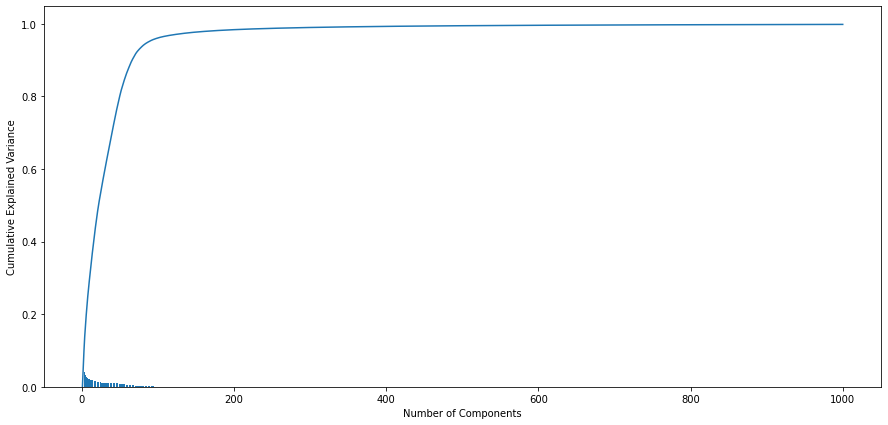

In [6]:
# Reduce number of dimensionality
svd = TruncatedSVD(n_components=1000, n_iter=10, random_state=42)
X_transformed = svd.fit_transform(X)

# Generate scree plot
create_variance_scree_plot(svd.explained_variance_ratio_)

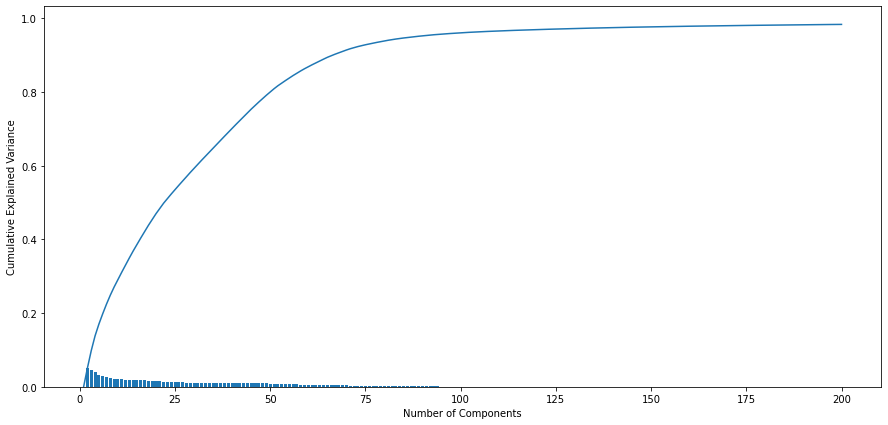

In [7]:
# Further dimensionality reduction
svd = TruncatedSVD(n_components=200, n_iter=10, random_state=42)
X_transformed = svd.fit_transform(X)

# Generate scree plot
create_variance_scree_plot(svd.explained_variance_ratio_)

In [45]:
X_transformed

array([[ 1.38546065e+01, -3.44040811e-01, -1.89845161e-01, ...,
        -3.25545620e-02,  1.71551783e-02,  1.02478289e-05],
       [ 1.38416415e+01, -3.66408757e-01,  7.61598582e-02, ...,
        -2.48185531e-02,  8.40721558e-03, -3.01608662e-02],
       [ 1.38546065e+01, -3.44040811e-01, -1.89845161e-01, ...,
        -3.25545620e-02,  1.71551783e-02,  1.02478289e-05],
       ...,
       [ 1.37341989e+01,  7.61808065e-01, -4.49139611e-02, ...,
        -8.38310089e-03, -5.02824053e-03, -5.21974308e-02],
       [ 1.37305982e+01,  7.64911098e-01, -4.34168450e-02, ...,
        -8.42314601e-03, -4.24036407e-02, -4.43376010e-03],
       [ 1.36432791e+01, -1.45305234e-01, -3.78891286e-01, ...,
        -2.16658693e-02, -2.67347854e-02, -1.87826877e-02]])

In [8]:
from sklearn.cluster import SpectralClustering

In [9]:
df_cleaned_data

,supplier_name,AC input frequency,AC input voltage,Accessory storage tray,Accuracy touch,Adhesion,Adhesive type,Adjustable angle,Adjustable armrest,Adjustable backrest,...,Weight (without accessories),Wi-Fi,Width,Width (imperial),Window,Windows operating systems supported,Working area,Working width,Writing colours,Zoom capability
2,HP,(N/A),(N/A),False,(N/A),(N/A),(N/A),False,False,False,...,0.0,False,0.0,0.0,False,NaN,(N/A),0.0,(N/A),(N/A)
3,HP,(N/A),(N/A),False,(N/A),(N/A),(N/A),False,False,False,...,0.0,False,541.0,0.0,False,NaN,(N/A),0.0,(N/A),(N/A)
4,HP,(N/A),(N/A),False,(N/A),(N/A),(N/A),False,False,False,...,0.0,False,0.0,0.0,False,NaN,(N/A),0.0,(N/A),(N/A)
5,Epson,(N/A),(N/A),False,(N/A),(N/A),(N/A),False,False,False,...,0.0,False,0.0,0.0,False,NaN,(N/A),0.0,(N/A),(N/A)
6,Epson,(N/A),(N/A),False,(N/A),(N/A),(N/A),False,False,False,...,0.0,False,0.0,0.0,False,NaN,(N/A),0.0,(N/A),(N/A)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7962,Legamaster,(N/A),(N/A),False,(N/A),(N/A),(N/A),False,False,False,...,0.0,False,1195.0,0.0,False,NaN,(N/A),0.0,(N/A),(N/A)
7963,Legamaster,(N/A),(N/A),False,(N/A),(N/A),(N/A),False,False,False,...,0.0,False,1195.0,0.0,False,NaN,(N/A),0.0,(N/A),(N/A)
7964,Legamaster,(N/A),(N/A),False,(N/A),(N/A),(N/A),False,False,False,...,0.0,False,595.0,0.0,False,NaN,(N/A),0.0,(N/A),(N/A)
7965,Legamaster,(N/A),(N/A),False,(N/A),(N/A),(N/A),False,False,False,...,0.0,False,595.0,0.0,False,NaN,(N/A),0.0,(N/A),(N/A)


In [17]:
n_labels = len(df_data.category_name.unique())

In [18]:
clustering = SpectralClustering(
    n_clusters=n_labels,
    assign_labels='discretize',
    affinity='rbf',
    random_state=42,
    verbose=True
)

In [19]:
clustering.fit(X_transformed)

/home/omar/.cache/pypoetry/virtualenvs/snow-leopard-O1gqMmLm-py3.8/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Computing label assignment using discretize


SpectralClustering(assign_labels='discretize', n_clusters=190, random_state=42,
                   verbose=True)

In [21]:
len(clustering.labels_)

7269

In [22]:
X_transformed.shape

(7269, 200)

In [23]:
df_data.shape

(7969, 1230)

In [25]:
df_data['cluster'] = None

In [27]:
df_cleaned_data.shape

(7269, 558)

In [28]:
df_cleaned_data['cluster'] = clustering.labels_

In [40]:
','.join([str(i) for i in clustering.labels_[0:100]])

'0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,35,0,35,35,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,0,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0'

In [36]:
df_data['cluster'] = df_cleaned_data['cluster'].astype(int)

In [42]:
df_export_data = df_data[['title', 'supplier_name', 'model_name', 'description_short',  'category_name', 'cluster']]

In [43]:
df_export_data.to_excel('../data/ice-cat-products-clusters.xlsx')